# Phase structure and migration

In this final (and simple!) project I examine the phase structure of planets as I move them closer to a star.
The aim here is to link the planet's external environment (its distance from the star) to its structure.
There are three key plots I want to produce here: planet radius with star--planet distance, phase structure with changing internal/external heating, and the path that the adiabat takes.

## Setup

In [2]:
using Ogre
using Ogre.Phases: PlanetModel, radius, phases
using Plots
using StatPlots
using ThesisUtils
using DataFrames
using DataFramesMeta
using LaTeXStrings
using ProgressMeter
using BasicUnits

## Planet/star system parameters

In [3]:
# Relation between radial distance and surface temperature
function Teq(Tstar, albedo, Rstar, distance)
    Tstar * (1 - albedo)^(1/4) * sqrt(Rstar/(distance))
end

const Tsun = 5800K
const Rsun = 7e8m
const albedo = 0

T_from_sun(distance) = Teq(Tsun, albedo, Rsun, distance)

# make a "migration track" (really just a parameter sweep across star--planet distance)
migration_track = logspace(log10(0.1au), log10(10au), 30)
# and across different values of ɛ and M
ɛs = [1e-10, 1e-12, 1e-14, 1e-18]
Ms = [1, 3, 5, 10] * M_earth;

## Data generation

In [7]:
# find the planet radius for each combination of M, D, ɛ
d = DataFrame(M=Float64[], D=Float64[], ɛ=Float64[], R=Float64[])
p = Progress(length(migration_track) * length(ɛs) * length(Ms))
for M in Ms, ɛ in ɛs, D in migration_track
    next!(p)
    Tirr = T_from_sun(D)
    pm = PlanetModel(Tirr=Tirr, M=M, ɛ=ɛ)
    R = radius(pm)
    
    push!(d, [M D ɛ R])
end
# and save them for later use
writetable("figdata/generated/migration-tracks/radius-with-migration.csv", d)

Progress:   7%|███                                      |  ETA: 0:01:21

INFO: Incomplete centre convergence (-1.2778011304028598e6 m)


Progress:   7%|███                                      |  ETA: 0:01:22

INFO: Incomplete centre convergence (602359.8164359883 m)


Progress:  13%|█████                                    |  ETA: 0:01:17

INFO: Incomplete centre convergence (-66658.07491920411 m)


Progress:  14%|██████                                   |  ETA: 0:01:17

INFO: Incomplete centre convergence (1.087007440493594e6 m)
INFO: Incomplete centre convergence (-2.7563683311327444e6 m)
INFO: Incomplete centre convergence (334567.40027017455 m)


Progress:  20%|████████                                 |  ETA: 0:01:11

INFO: Incomplete centre convergence (975488.2594382114 m)


Progress:  20%|████████                                 |  ETA: 0:01:11

INFO: Incomplete centre convergence (-204195.90114305832 m)
INFO: Incomplete centre convergence (-1.2268042670101188e6 m)


Progress:  38%|████████████████                         |  ETA: 0:00:54

INFO: Incomplete centre convergence (736482.1149189863 m)


Progress:  44%|██████████████████                       |  ETA: 0:00:49

INFO: Incomplete centre convergence (769012.2407673023 m)


Progress:  57%|███████████████████████                  |  ETA: 0:00:37

INFO: Incomplete centre convergence (595833.6387010152 m)


Progress:  64%|██████████████████████████               |  ETA: 0:00:31

INFO: Incomplete centre convergence (825190.5570093768 m)


Progress:  74%|██████████████████████████████           |  ETA: 0:00:22

INFO: Incomplete centre convergence (1.297273453839379e6 m)


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:10

INFO: Incomplete centre convergence (-1.2358213573266685e7 m)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:05

INFO: Incomplete centre convergence (-63783.45817629696 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


## Plots

In [6]:
phaseboundaries = WaterData.load_phase_boundaries()["boundaries"]
evapboundary = phaseboundaries["iapws"]
otherboundaries = phaseboundaries["dunaeva"]

@recipe function plot(b::WaterData.PhaseBoundary)
    seriestype := :line
    linewidth --> 1
    label --> ""

    b.P, b.T
end


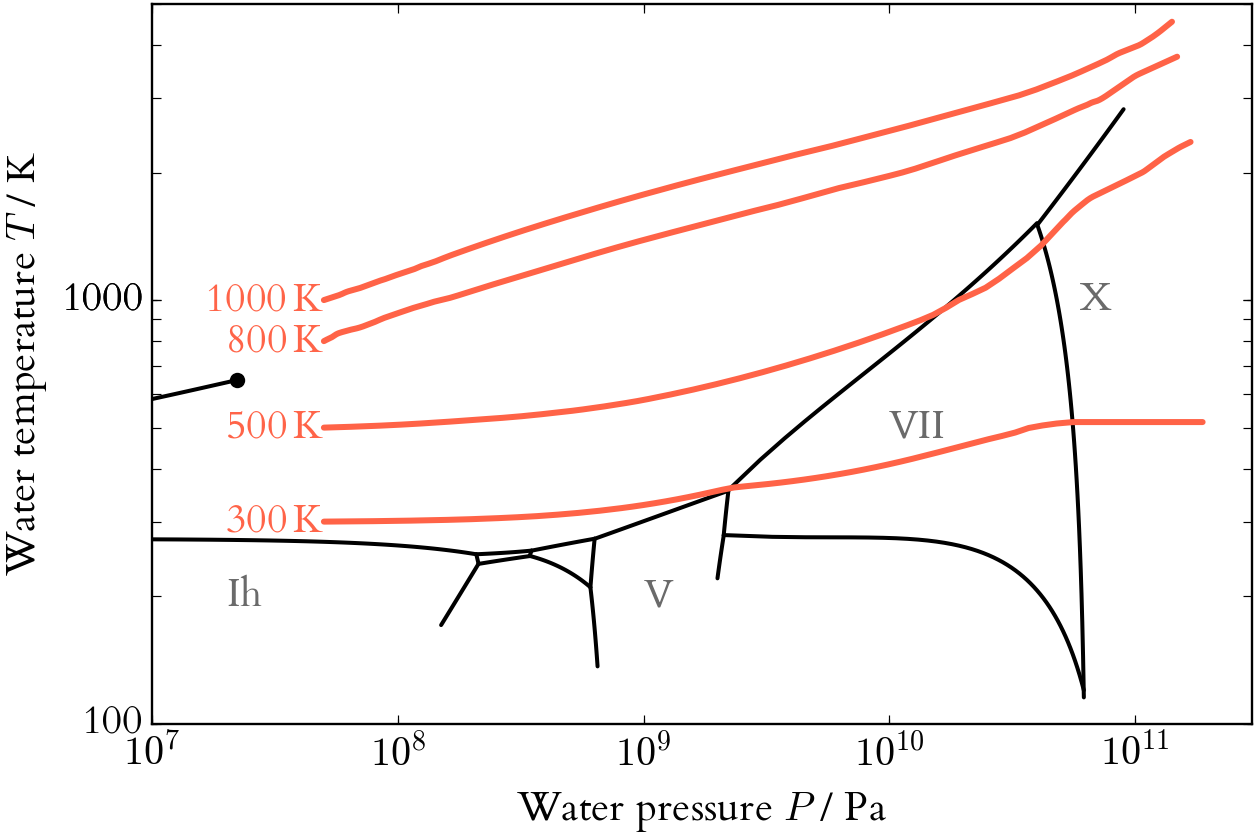

In [49]:
function adiabat_watersphere(M, Psurf, Tsurf)
    Rbracket = [0, 5] * R_earth
    Npoints = 500
    full_h2o_eos = WaterData.load_full_eos()["grid"]
    cₚ = WaterData.load_heat_capacity()["heatcap_h2o"]
    bvs = Ogre.ValueSet(M, R_earth, Psurf, Tsurf)
    grid = Ogre.mass_grid(M, 0.5, Npoints)
    planet = Ogre.PlanetSystem(M, full_h2o_eos, cₚ, bvs, grid, Rbracket)
    structure = Ogre.find_structure!(planet)
    P = Ogre.pressure(structure)
    T = Ogre.temperature(structure)
    
    return P, T
end

autofig("pressure-temperature-profiles", Normal) do
    # vapour curve
    plot(evapboundary, 
        c=:black,
        legend=false)
    Tfmt = T -> (T in [100, 1000] ? round(Int,T) : "")
    Tticks = vcat(100:100:1000, 1000:1000:25000)
    xaxis!((1e7, 3e11),  :log10, L"Water pressure $P$ / Pa")
    yaxis!((1e2, 5e3), Tticks, :log10, L"Water temperature $T$ / K", Tfmt)
    
    # dot at critical point
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    scatter!([Pcrit], [Tcrit], label="", markersize=5, markerstrokewidth=0, c=:black)
    
    # phase boundaries
    plot!([1e5, 4.1e6], [2.7e2, 2.72e2], c=:black, label="")
    foreach(otherboundaries) do b
        plot!(b, c=:black)
    end
    
    # models
    Tsurfs = [300, 500, 800, 1000]
    M = 3M_earth
    
    for T in Tsurfs
        Ps, Ts = adiabat_watersphere(M, 5e7, T)
        plot!(Ps, Ts, c=:tomato)
        annotate_color!(5e7, T, latexstring("$T\$\\,\$K "), :tomato, position=:right)
    end
    
    annotate_color!(2e7, 2e2, "Ih", :dimgrey)
    annotate_color!(1e9, 2e2, "V", :dimgrey)
    annotate_color!(1e10, 5e2, "VII", :dimgrey)
    annotate_color!(6e10, 1e3, "X", :dimgrey)
end


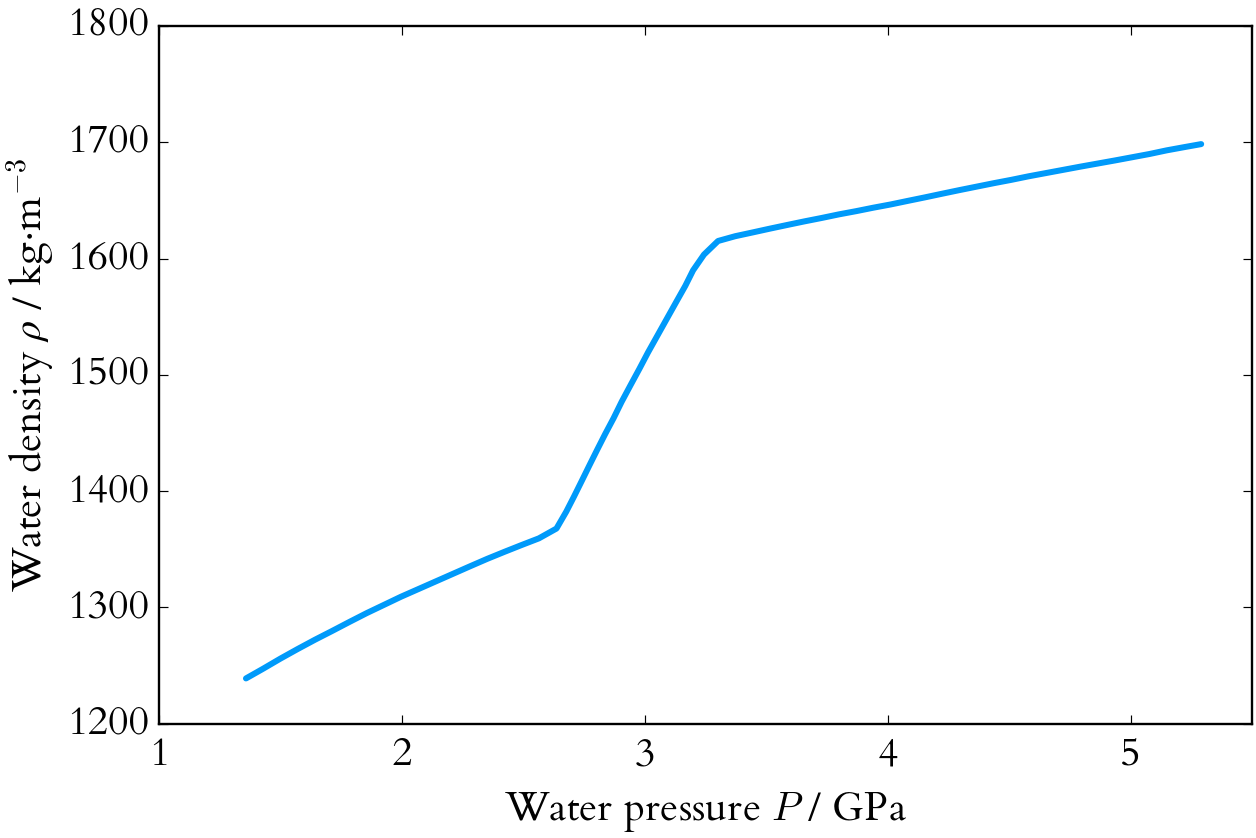

In [12]:
autofig("density-jump", Normal) do
    density_across_boundary = readtable("figdata/raw/phase-boundaries/density-across-boundary.csv", allowcomments=true)

    @with density_across_boundary begin
        plot(:pressure, :density, label="")
    end
    xaxis!(L"Water pressure $P$ / GPa", (1, 5.5))
    yaxis!(L"Water density $ρ$ / kg$⋅$m$^{-3}$", (1200, 1800))
end


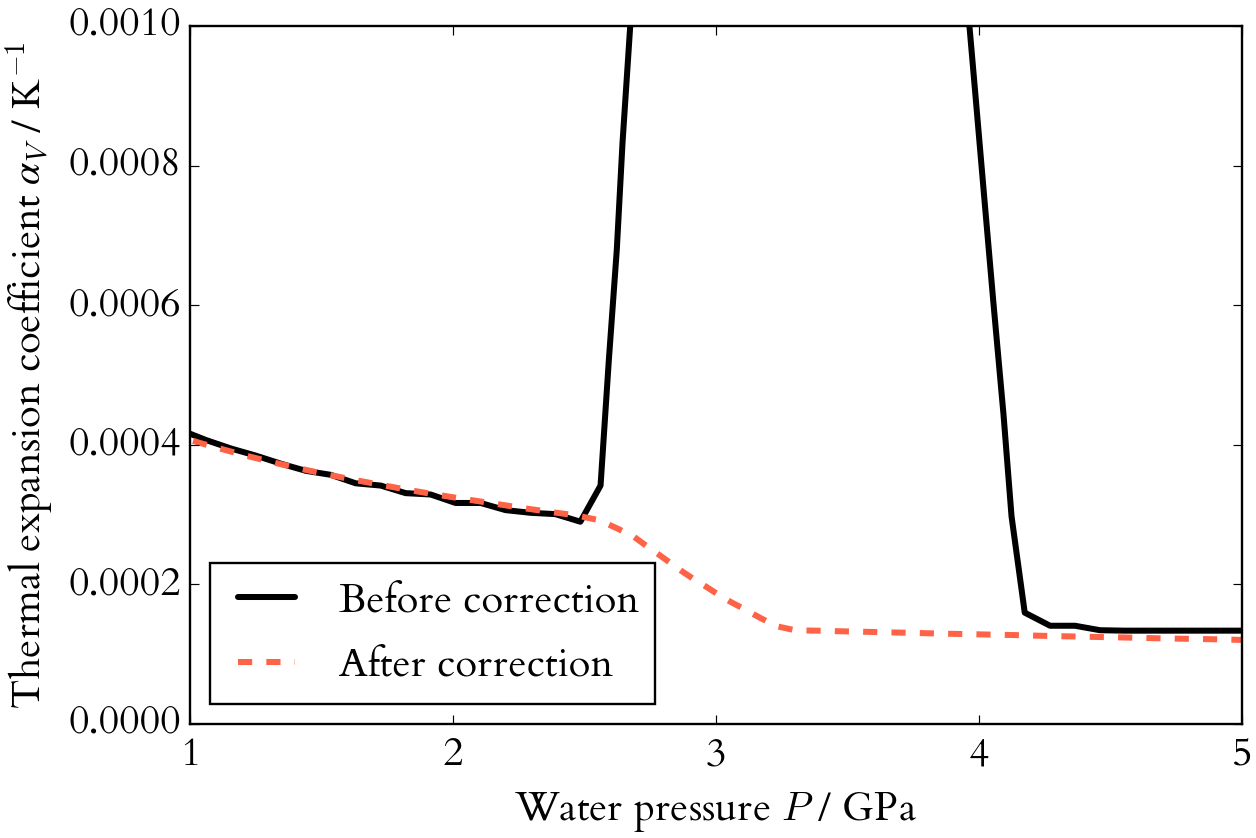

In [29]:
autofig("thermal-expansivity-correction", Normal) do
    expansion_spike = readtable("figdata/raw/phase-boundaries/expansion-coefficient-spike.csv", allowcomments=true)
    expansion_corrected = readtable("figdata/raw/phase-boundaries/expansion-coefficient-corrected.csv", allowcomments=true)
    @with expansion_spike begin
        plot(:pressure, :alpha, label="Before correction", c="black")
    end
    @with expansion_corrected begin
        plot!(:pressure, :alpha, label="After correction", s=^(:dash), c="tomato")
    end
    xaxis!(L"Water pressure $P$ / GPa", (1, 5))
    yaxis!(L"Thermal expansion coefficient $α_V$ / K$^{-1}$", (0, 0.001))
end


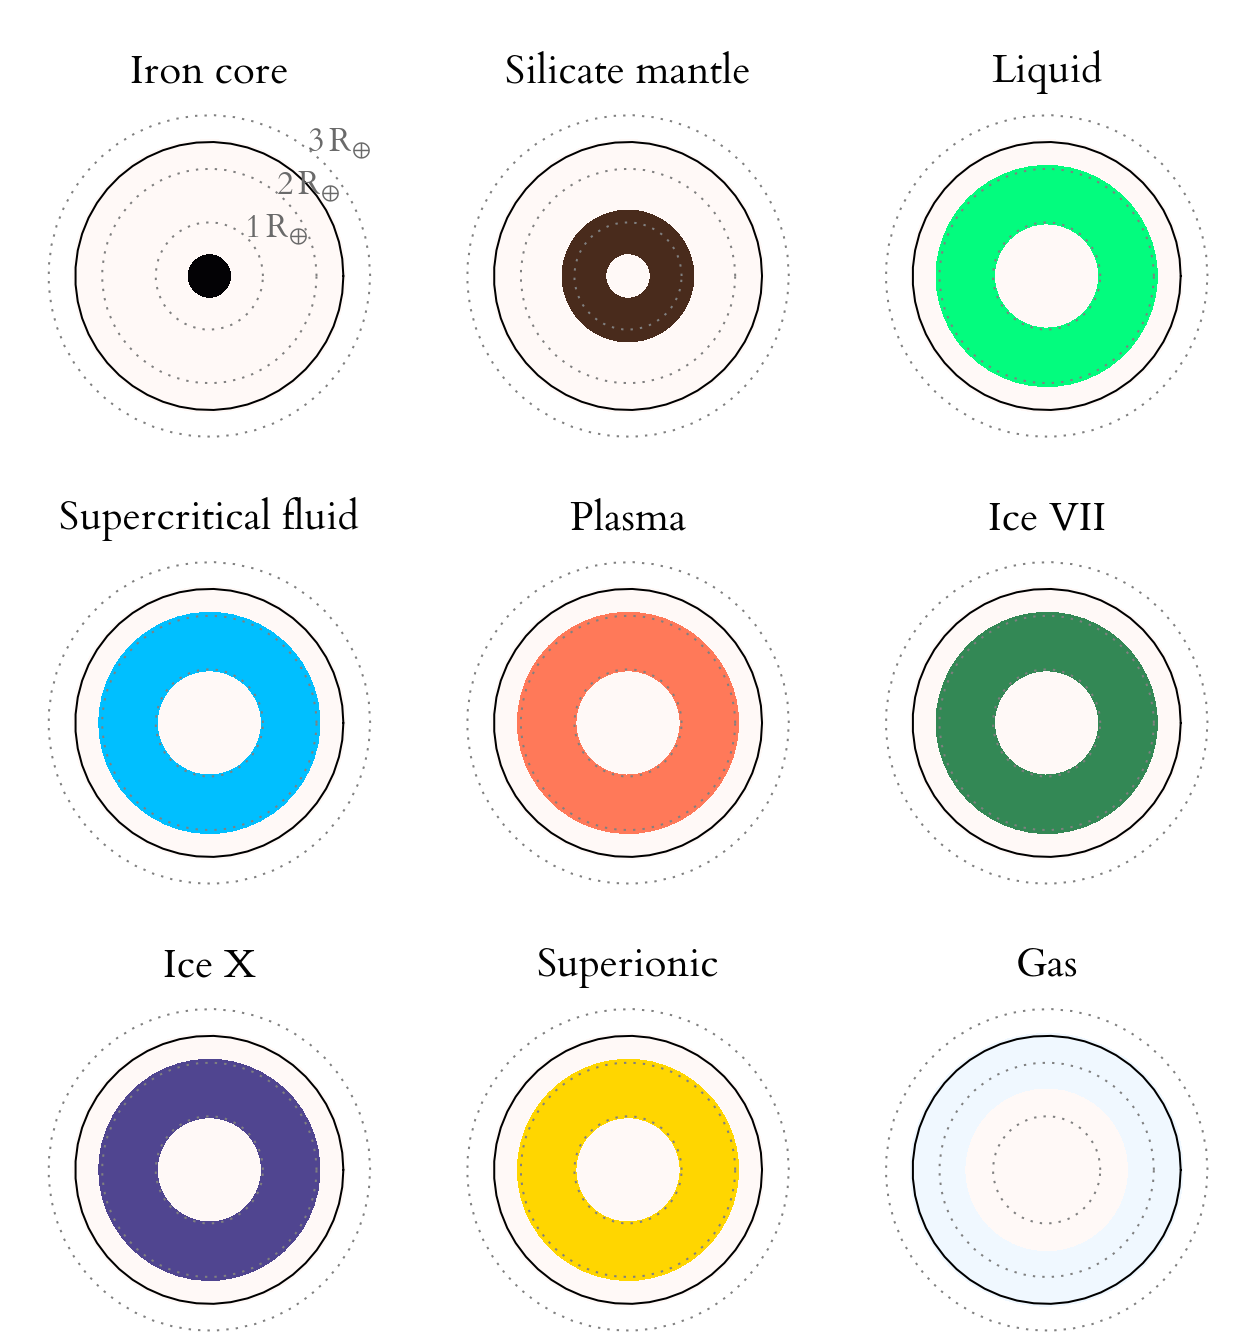

In [10]:
function phase_key()
    PlanetPhases = Ogre.Phases.PlanetPhases
    Iron = Ogre.Phases.Iron
    Nothing = Ogre.Phases.Nothing
    Silicate = Ogre.Phases.Silicate
    Supercritical = Ogre.Phases.SupercriticalFluid
    Superionic = Ogre.Phases.Superionic
    Gas = Ogre.Phases.Gas
    Liquid = Ogre.Phases.Liquid
    Plasma = Ogre.Phases.Plasma
    VII = Ogre.Phases.VII
    X = Ogre.Phases.X

    layout = grid(3, 3)
    plots = []
    ls = linspace(0, 2.5R_earth, 10)

    # iron phase and grid labels
    phases1 = [Iron, Iron, repeated(Nothing, 8)...]
    s1 = PlanetPhases(ls, phases1)
    plot1 = plot(s1, title="Iron core")
    annotate_color!(0.3π, 1.1, L"1$\,$R$_⊕$", :dimgrey, plotsize=Margin)
    annotate_color!(0.3π, 2.1, L"2$\,$R$_⊕$", :dimgrey, plotsize=Margin)
    annotate_color!(0.3π, 3.1, L"3$\,$R$_⊕$", :dimgrey, plotsize=Margin)
    push!(plots, plot1)
    
    function add_phase!(phase, name; range=5:8)
        phase_grid = collect(repeated(Nothing, 10))
        phase_grid[range] = phase
        structure = PlanetPhases(ls, phase_grid)
        push!(plots, plot(structure, title=name))
    end
    
    add_phase!(Silicate, "Silicate mantle", range=3:5)
    add_phase!(Liquid, "Liquid")
    add_phase!(Supercritical, "Supercritical fluid")
    add_phase!(Plasma, "Plasma")
    add_phase!(VII, "Ice VII")
    add_phase!(X, "Ice X")
    add_phase!(Superionic, "Superionic")
    add_phase!(Gas, "Gas", range = 7:10)

    plot(plots..., layout=layout, ylim=(0,3.1))
end

autofig("phase-key", Normal, vscale=1.6, savepng=true) do
    phase_key()
end

In [25]:
function plot_migration(M, ann_y)
    # load in the data
    d = readtable("figdata/generated/migration-tracks/radius-with-migration.csv")
    # get the list of ɛs
    ɛsyms = [Symbol(ɛ) for ɛ in levels(d[:ɛ])]
    # make wide format for plotting
    d = unstack(d, :ɛ, :R)
    # select only the current mass
    d = @where(d, :M .== M)
    
    # lay out the plot grid
    layout = @layout [ a ; grid(4,5) ]
    p = plot(layout=layout)
    Nplots = 1 + 4*5
    
    # top plot (migration track)
    temp_at_distance(D) = T_from_sun(D)
    colors = ThesisUtils.seqcolors(:redsblues, 4)
    
    Dfmt = D -> D/au
    Dticks = [0.1, 0.5, 1, 5, 10] * au
    Dlim = (0.095au, 10.4au)
    Rfmt = R -> R/R_earth
    Rticks = [1, 2, 3] * R_earth
    Rlim = (0.95R_earth, 3.05R_earth)
    Tfmt = D -> round(Int, T_from_sun(D))
    Tticks = [0.1, 0.5, 1, 5, 10] * au
    Tlim = Dlim
    
    x = d[:, :D]
    ys = Array(d[:, ɛsyms])
    plot!(p[1], x, ys,
        xformatter=Dfmt,
        yformatter=Rfmt,
        palette=colors,
        legend=false,
        top_margin=100px,
        xaxis=(Dlim, Dticks, L"Planet–star distance $D$ / au", :log10),
        yaxis=(Rlim, Rticks, L"Radius of planet $R_\mathrm{P}$ / R$_⊕$"))
    
    annotate_color!(p[1], 2.5au, ann_y[1]*R_earth, L"$ɛ$ = 10$^{-10}\,$W$⋅$kg$^{-1}$", colors[1])
    annotate_color!(p[1], 5au, ann_y[2]*R_earth, L"10$^{-12}$", colors[2])
    annotate_color!(p[1], 5au, ann_y[3]*R_earth, L"10$^{-14}$", colors[3])
    annotate_color!(p[1], 5au, ann_y[4]*R_earth, L"10$^{-18}$", colors[4])
    mymass = round(Int, M/M_earth)
    annotate_color!(p[1], 0.1au, 1.05R_earth, latexstring("\$$mymass\\,\$M\$_⊕\$"), :black)
    
    # pull out some structures for specific points in that migration track
    sample_indices = [1, 4, 8, 16, 30]
    structures = map(ɛs) do ɛ
        map(migration_track[sample_indices]) do D
            Tirr = T_from_sun(D)
            pm = PlanetModel(Tirr=Tirr, ɛ=ɛ, M=M)
            ps = phases(pm)
        end
    end
    structures = hcat(structures...);
    
    # indicate where we sampled from
    scatter!(p[1], x[sample_indices], ys[sample_indices, :], 
        xformatter=Tfmt,
        xscale=:log10,
        xlabel=L"Irradiation temperature $T_\mathrm{irr}$ / K",
        xmirror=true, 
        ylink=1, 
        inset=(1,bbox(0,0,1,1)), 
        bg_inside=RGBA(0,0,0,0), 
        subplot=Nplots+1,
        yformatter=R->"",
        palette=colors, 
        markerstrokewidth=0,
        markersize=6,
        legend=false,
        xaxis=(Tlim, Tticks, :log10),
        ylims=Rlim)

    # bottom plot (phase structure)
    structureplots = []
    for (n, s) in enumerate(structures)
        plot!(p[n+1], s, ylim=(0,3.1), colorbar=false)
    end
    
    p
end

ann_ys = Dict(
    Ms[1] => [2.45, 1.77, 1.52, 1.28],
    Ms[2] => [2.35, 2, 1.83, 1.65],
    Ms[3] => [2.41, 2.18, 2.03, 1.87],
    Ms[4] => [2.61, 2.45, 2.21, 2.05],
)
for M in Ms
    M_Mearth = trunc(Int, M/M_earth)
    autofig("migration-$(M_Mearth)Mearth", Normal, savepng=true, vscale=2.6) do
        plot_migration(M, ann_ys[M])
    end
end

INFO: Incomplete centre convergence (-66658.07491920411 m)
INFO: Incomplete centre convergence (334567.40027017455 m)
INFO: Incomplete centre convergence (975488.2594382114 m)
INFO: Incomplete centre convergence (-1.2358213573266685e7 m)
INFO: Incomplete centre convergence (-63783.45817629696 m)
